In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import zipfile
import os
import cv2
from tqdm import tqdm

C:\Users\computer world\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preprocessing and viewing Data

In [2]:
# Lets first view the csv datasets and see how they look

stage1_solution = pd.read_csv("stage1_solution.csv")
stage1_train_labels = pd.read_csv("stage1_train_labels.csv")
stage1_submission = pd.read_csv("stage1_sample_submission.csv")
stage2_submission = pd.read_csv("stage2_sample_submission_final.csv")

In [13]:
stage1_solution

,ImageId,EncodedPixels,Height,Width,Usage
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31632 6 31886 10 32139 14 32394 15 32649 17 32...,256,256,Public
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50280 7 50534 10 50788 13 51043 14 51298 16 51...,256,256,Public
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10892 5 11146 9 11401 10 11656 11 11911 13 121...,256,256,Public
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45104 8 45359 10 45614 12 45869 14 46124 15 46...,256,256,Public
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,38564 4 38819 6 39074 8 39327 11 39582 12 3983...,256,256,Public
...,...,...,...,...,...
4147,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,53498 4 53753 5 53759 1 54009 8 54265 8 54520 ...,256,256,Public
4148,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,56869 4 57124 7 57379 9 57634 11 57890 12 5814...,256,256,Public
4149,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,20376 1 20630 4 20884 7 20893 1 21140 12 21395...,256,256,Public
4150,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,15891 3 16142 11 16398 12 16653 14 16908 15 17...,256,256,Public


EncodedPixels shows the Run Length Encoding for masks

In [4]:
#Extracting Image from zip file

with zipfile.ZipFile("stage1_train.zip") as z:
    z.extractall("stage1_train")
    
with zipfile.ZipFile("stage1_test.zip") as z:
    z.extractall("stage1_test")

Now we don't know the size/dimension of any of the images so lets check one out and just visualize how some images look like

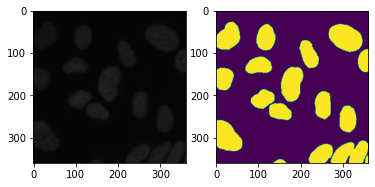

In [3]:
train_path = "stage1_train"
test_path = "stage1_test"

train_dir = os.listdir(train_path)
test_dir = os.listdir(test_path)

image1_path  = train_dir[10]
images = os.listdir("stage1_train/"+image1_path+"/images")
masks = os.listdir("stage1_train/"+image1_path+"/masks")

directory_image = f'stage1_train/{image1_path}/images'
directory_masks = f'stage1_train/{image1_path}/masks'
image_file = images[0]
mask_file = masks[0]

image_path = os.path.join(directory_image,image_file)
mask_ = 0
for msk in masks:
    mask_path = os.path.join(directory_masks,msk)
    mask = plt.imread(mask_path)
    #mask = cv2.resize(mask,(256,256))
    mask = np.expand_dims(mask,axis=-1)
    mask_ = np.maximum(mask_,mask)

    
image = cv2.imread(image_path)
#img_ = cv2.resize(image,(256,256))


fig,ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(mask_)
plt.show()

In [257]:
#Both are 360 x 360 we will resize to 256 x 256 later on

print(image.shape)
print(mask_.shape)

(360, 360, 3)
(360, 360, 1)


When doing this i had confusion of what the images are themselves, like what they represent, i researched and got understanding, so i am just going to put it here for anyone else who has that confusion : 

The images in the training set are pictures of cells from different types of microscopy, such as fluorescence microscopy, phase contrast microscopy, or confocal microscopy1. The images show the whole cell, including the cytoplasm and the nucleus, but with different levels of contrast and brightness. The masks are binary images that indicate the location and shape of the nuclei in the cells. The masks are usually white for the nuclei and black for the background. The masks are used to label the nuclei for the segmentation task

The images are from different types of cells that are grown in a laboratory. The cells may come from different sources, such as human tissue, mouse tissue, or synthetic cells. The nuclei are showing in the images as brighter or darker patches depending on the type of microscopy and staining used. The task is to take the images and segment the nuclei in them, which means to draw a boundary around each nucleus and separate it from the background and other nuclei.

In [233]:
print(f' train length : {len(train_dir)}')
print(f' test length : {len(test_dir)}')

 train length : 670
 test length : 65


There are just 670 images for training and 65 for test, we will apply data augmentation to improve model generalization

In [12]:
#First we will combine all the masks as we did before with np.maximum and create X_train and Y_train

IMG_HEIGHT = 128
IMG_WIDTH = 128

X_train = np.zeros((len(train_dir),IMG_HEIGHT,IMG_WIDTH,3),dtype=np.uint8)
y_train = np.zeros((len(train_dir),IMG_HEIGHT,IMG_WIDTH,1),dtype=bool)

X_test = np.zeros((len(test_dir),IMG_HEIGHT,IMG_WIDTH,3),dtype=np.uint8)

print("Preparing Train data")
for num,data in tqdm(enumerate(train_dir)):
    directory_image = f'stage1_train/{data}/images'
    directory_masks = f'stage1_train/{data}/masks'
    
    image_dir = os.listdir('stage1_train/'+data+'/images')
    masks  = os.listdir('stage1_train/'+data+'/masks')
    
    image_path = os.path.join(directory_image,''.join(image_dir))
    image = cv2.imread(image_path)
    image = cv2.resize(image,(IMG_HEIGHT,IMG_WIDTH))
    
    X_train[num] = image
    
    mask_ = np.zeros((IMG_HEIGHT,IMG_WIDTH,1),dtype=bool)
    for mask_name in masks:
        mask_path = os.path.join(directory_masks,mask_name)
        mask = cv2.imread(mask_path,0)
        mask = cv2.resize(mask,(IMG_HEIGHT,IMG_WIDTH))
        mask = np.expand_dims(mask,axis=-1)
        mask_ = np.maximum(mask_,mask)
        
        
    y_train[num] = mask_
    
print("Preparing Test Data")
for num, data in tqdm(enumerate(test_dir)):
    directory_test = f'stage1_test/{data}/images'
    image_dir = os.listdir('stage1_test/'+data+'/images')
    
    image_path = os.path.join(directory_test,''.join(image_dir))
    image = cv2.imread(image_path)
    image = cv2.resize(image,(IMG_HEIGHT,IMG_WIDTH))
    
    X_test[num] = image

Preparing Train data


670it [00:31, 21.16it/s]


Preparing Test Data


65it [00:00, 115.15it/s]


Now We apply data Augmentation with ImageDataGenerator and create our data generators

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,
                                   zoom_range=0.2,width_shift_range=0.2,
                                   height_shift_range=0.3,horizontal_flip=True,
                                  vertical_flip=True,channel_shift_range=0.5,)

val_datagen =  ImageDataGenerator(1./255)
X_test_processed = (X_test-X_test.min(axis=0))/(X_test.max(axis=0)-X_test.min(axis=0)) #Standardizing the test set

We want to see the effect on data augmentation on a single image data,
For us to do that we need to rescale the single data image to a size acceptable by ImageDataGenerator,
ImageDataGenerator expects data to be in batches, since we are passing a single Image our batch would be one
and we will expand in dimension from (256,256,3) to (1,256,256,3)

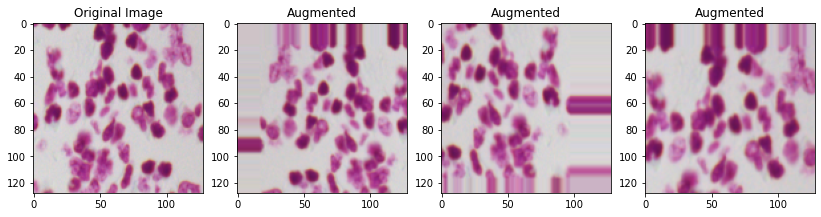

In [14]:
#Lets see how it works on one image

aug_image_ = np.expand_dims(X_train[2],axis=0)
aug_mask_ = np.expand_dims(y_train[2],axis=0)

aug_gen = train_datagen.flow(aug_image_,aug_mask_,batch_size=1,shuffle=False,seed=123)

fig,ax = plt.subplots(1,4,figsize=(14,12))
ax[0].imshow(X_train[2])
ax[0].set_title("Original Image")
for num,batch in enumerate(aug_gen):
    if num==3:
        break
    else:
        ax[num+1].imshow(np.squeeze(batch[0],axis=0))
        ax[num+1].set_title("Augmented")

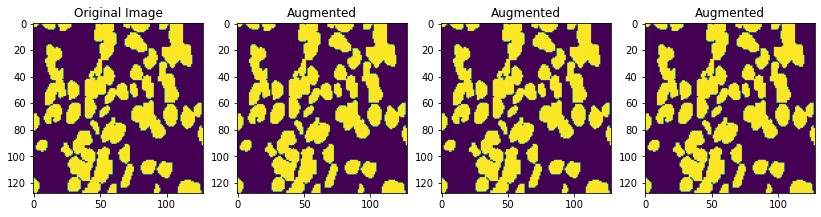

In [15]:
#For the maskes

fig,ax = plt.subplots(1,4,figsize=(14,12))
ax[0].imshow(y_train[2])
ax[0].set_title("Original Image")
for num,batch in enumerate(aug_gen):
    if num==3:
        break
    else:
        ax[num+1].imshow(np.squeeze(batch[1],axis=0))
        ax[num+1].set_title("Augmented")

Now lets create our train and test generators from ImageDataGenerator

In [16]:
#Splitting data into train and validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0)

train_datagen.fit(X_train,augment=True,seed=123)

train_gen = train_datagen.flow(X_train,y_train,batch_size=32,seed=123,shuffle=False)
val_gen = val_datagen.flow(X_val,y_val,batch_size=32,seed=123,shuffle=False)

## Model Building

In [32]:
#So the Unet Architecture is quite special, first we will decrease the channels, then increase it, 
#while also providing skip conncetions

"""
from tensorflow.keras import layers


class UnetDownSample(layers.Layer):
    def __init__(self,channels,kernel_size=3):
        super(UnetDownSample,self).__init__()
        self.conv = layers.Conv2D(filters = channels,kernel_size=kernel_size,
                                  activation="relu",kernel_initializer='he_normal',padding="same")
        self.dropout = layers.Dropout(rate=0.2)
        self.maxpool = layers.MaxPooling2D(strides=2,pool_size=(2,2))
        
    def call(self,input_tensor,training=False):
        x = self.conv(input_tensor)
        x = self.dropout(x,training=training)
        x = self.conv(x)
        x = self.maxpool(x)
        return x
    
    
class UnetUpSample(layers.Layer):
    def __init__(self,channels,concat_layer):
        super(UnetUpSample,self).__init__()
        self.concat_layer = concat_layer
        self.transpose_conv = layers.Conv2DTranspose(filters=channels,kernel_size=2,
                                                     padding="same",strides=2)
        self.conv = layers.Conv2D(filters = channels,kernel_size=3,activation="relu",
                                  padding="same",kernel_initializer="he_normal")
        
    def call(self,input_tensor,training=False):
        x = self.transpose_conv(input_tensor)
        x = layers.concatenate([x,self.concat_layer])
        x = self.conv(x)
        return x
    
class UnetModel(tf.keras.Model):
    def __init__(self):
        super(UnetModel,self).__init__()
        self.downsample1 = UnetDownSample(16)
        self.downsample2 = UnetDownSample(32)
        self.downsample3 = UnetDownSample(64)
        self.downsample4 = UnetDownSample(128)
        self.upsample1 = UnetUpSample(128,self.downsample4)
        self.upsample1 = UnetUpSample(64,self.downsample3)
        self.upsample1 = UnetUpSample(32,self.downsample2)
        self.upsample1 = UnetUpSample(16,self.downsample1)
    
    def call(self,input_tensor, training=False):
        x = self.downsample1(input_tensor)
        x = self.downsample2(x)
        x = self.downsample3(x)
        x = self.downsample4(x)
        x = layers.Conv2D(filters = 256,kernel_size=3,
                                  activation="relu",kernel_initializer='he_normal',padding="same")(x) #bottom
        x = layers.Dropout(rate=0.2)(x)
        x = layers.Conv2D(filters = 256,kernel_size=3,
                                  activation="relu",kernel_initializer='he_normal',padding="same")(x)
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.upsample4(x)
        x = layers.Conv2D(1, (1,1), activation='sigmoid')
        return x
        
    def model(self):
        input_shape = (256,256,3)
        x = keras.Input(shape=input_shape)
        return tf.keras.Model(inputs=x,outputs=self.call(x))
        
model = UnetModel()

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.binary_crossentropy,
              metrics=tf.keras.metrics.MeanIoU(num_classes=2))
              
model.fit(train_gen,epochs=10,verbose=True,validation_data=val_gen)"""

The code above was giving an error when i called model.fit(), something due to the input tensor shape not getting what it expected, after multiple tries i still couldn't find a fix for it, so i redesigned the model to the one below, i preferred this upper method cause it felt more clean and readable though, if you are reading this and you find a fix, kindly let me know how 

In [11]:
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Conv2DTranspose,concatenate,UpSampling2D
#Build the model
inputs = tf.keras.layers.Input(shape = (IMG_HEIGHT,IMG_WIDTH,3))

#Contraction path
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3), loss='binary_crossentropy', metrics=tf.keras.metrics.MeanIoU(num_classes=2))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [17]:
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Conv2DTranspose,concatenate,UpSampling2D
#Build the model
inputs = tf.keras.layers.Input(shape = (IMG_HEIGHT,IMG_WIDTH, 3))

c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(inputs) # start with normal distributed weights
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3), loss='binary_crossentropy', metrics=tf.keras.metrics.MeanIoU(num_classes=2))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_39 (Conv2D)          (None, 128, 128, 16)         448       ['input_3[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 16)         0         ['conv2d_39[0][0]']           
                                                                                                  
 conv2d_40 (Conv2D)          (None, 128, 128, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

 conv2d_transpose_7 (Conv2D  (None, 128, 128, 16)         2064      ['conv2d_54[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_11 (Concatenat  (None, 128, 128, 32)         0         ['conv2d_transpose_7[0][0]',  
 e)                                                                  'conv2d_40[0][0]']           
                                                                                                  
 conv2d_55 (Conv2D)          (None, 128, 128, 16)         4624      ['concatenate_11[0][0]']      
                                                                                                  
 dropout_17 (Dropout)        (None, 128, 128, 16)         0         ['conv2d_55[0][0]']           
                                                                                                  
 conv2d_56

In [18]:
history = model.fit(train_gen,epochs=10,verbose=True,validation_data=val_gen)

Epoch 1/10
19/19 [==============================] - 75s 4s/step - loss: 2.9192 - mean_io_u_2: 0.4239 - val_loss: 22.9184 - val_mean_io_u_2: 0.4208
Epoch 2/10
19/19 [==============================] - 69s 4s/step - loss: 0.4710 - mean_io_u_2: 0.4239 - val_loss: 16.7884 - val_mean_io_u_2: 0.4206
Epoch 3/10
19/19 [==============================] - 69s 4s/step - loss: 0.4302 - mean_io_u_2: 0.4239 - val_loss: 14.6777 - val_mean_io_u_2: 0.4207
Epoch 4/10
19/19 [==============================] - 68s 4s/step - loss: 0.4274 - mean_io_u_2: 0.4239 - val_loss: 13.1711 - val_mean_io_u_2: 0.4207
Epoch 5/10
19/19 [==============================] - 68s 4s/step - loss: 0.4278 - mean_io_u_2: 0.4239 - val_loss: 11.8210 - val_mean_io_u_2: 0.4207
Epoch 6/10
19/19 [==============================] - 68s 4s/step - loss: 0.4265 - mean_io_u_2: 0.4239 - val_loss: 12.3917 - val_mean_io_u_2: 0.4207
Epoch 7/10
19/19 [==============================] - 69s 4s/step - loss: 0.4257 - mean_io_u_2: 0.4239 - val_loss: 12.00

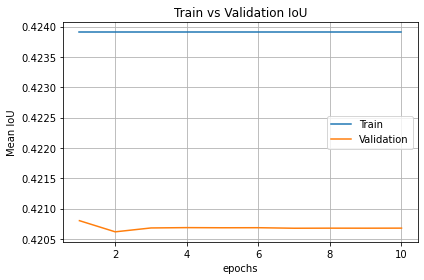

In [20]:
epochs = list(range(1,11))

plt.plot(epochs,history.history['mean_io_u_2'],label="Train")
plt.plot(epochs, history.history['val_mean_io_u_2'],label="Validation")
plt.title("Train vs Validation IoU")
plt.xlabel("epochs")
plt.ylabel("Mean IoU")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

Yep, Utterly terrible as expected, the better models will be the ones that generated over 10million paramaters, but my kernel keeps crashing when i run them, looks like my laptop cpu isn't strong enough for them, yes i worked on this on my local pc, so you can try those models, also change the shape to 256,256 instead of 128,128 that it is now

In [21]:
test_pred = model.predict(X_test_processed, verbose=1)

3/3 [==============================] - 2s 341ms/step


In [ ]:
plt.figure(figsize=(10, 15))
for i,num in enumerate(range(421, 429)):
    plt.subplot(num)
    if i % 2!=0:
        plt.imshow(X_test[i])
        plt.title('Original image')
    else:
        plt.imshow(np.squeeze(test_pred[i-1]))
        plt.title('Predicted image')

In [35]:
from skimage.transform import resize
# Predict on train, val and test
preds_train = model.predict(train_gen, verbose=1)
preds_val = model.predict(val_gen, verbose=1)
preds_test = model.predict(X_test_processed, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (IMG_HEIGHT,IMG_WIDTH ), 
                                       mode='constant', preserve_range=True))

3/3 [==============================] - 1s 345ms/step


In [51]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
from skimage.morphology import label
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
new_test_ids = []
rles = []
for n, id_ in enumerate(test_dir):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [40]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

In [41]:
uu = pd.read_csv('sub-dsbowl2018-1.csv')
uu.head()

,ImageId,EncodedPixels
